<a href="https://colab.research.google.com/github/aman-mishra7/Fake-Social-Media-Profile_Detection-and-Reporting/blob/main/Copy_of_Actual_work_of_frauddetect_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/credit_details

/content/drive/MyDrive/credit_details


In [ ]:
card_info = pd.read_csv('cc_info.csv')
transaction_info = pd.read_csv('transactions.csv')

In [ ]:
card_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [ ]:
transaction_info.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [ ]:
#check for missing values
card_info.isnull().sum()

,0
credit_card,0
city,0
state,0
zipcode,0
credit_card_limit,0


In [ ]:
#check for missing values
transaction_info.isnull().sum()

,0
credit_card,0
date,0
transaction_dollar_amount,0
Long,0
Lat,0


In [ ]:
# checking for duplicate data in both datasets

# Check for duplicate data in card_info
print("Duplicate rows in card_info:", card_info.duplicated().sum())

# Check for duplicate data in transaction_info
print("Duplicate rows in transaction_info:", transaction_info.duplicated().sum())


Duplicate rows in card_info: 0
Duplicate rows in transaction_info: 0


In [ ]:
#merge two dataframes
data = transaction_info.merge(card_info, on = 'credit_card')

In [ ]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [ ]:
print(f"data shape: {data.shape}")
print(f"data size: {data.size}")

data shape: (294588, 9)
data size: 2651292


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
 5   city                       294588 non-null  object 
 6   state                      294588 non-null  object 
 7   zipcode                    294588 non-null  int64  
 8   credit_card_limit          294588 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 20.2+ MB


In [ ]:
data['date'] = pd.to_datetime(data['date'])
# Set 'date' as index for time series analysis
data.set_index('date', inplace=True)

In [ ]:
print(f"data shape after cleaning: {data.shape}")
print(f"data size after cleaning: {data.size}")

data shape after cleaning: (294588, 8)
data size after cleaning: 2356704


In [ ]:
# Summary statistics for numeric columns
print(data.describe())


        credit_card  transaction_dollar_amount           Long            Lat  \
count  2.945880e+05              294588.000000  294588.000000  294588.000000   
mean   5.424562e+15                  86.008036     -76.235238      40.937669   
std    2.555803e+15                 124.655954      20.135015       5.391695   
min    1.003715e+15                   0.010000    -179.392887     -68.046553   
25%    3.344214e+15                  29.970000     -80.209708      40.487726   
50%    5.353426e+15                  58.470000     -73.199737      42.403066   
75%    7.646245e+15                 100.400000     -72.091933      43.180015   
max    9.999757e+15                 999.970000     179.917513      78.914330   

             zipcode  credit_card_limit  
count  294588.000000      294588.000000  
mean    18073.772516       15502.053716  
std     23945.510551        7956.291556  
min       690.000000        2000.000000  
25%      3280.000000       10000.000000  
50%      5820.000000       

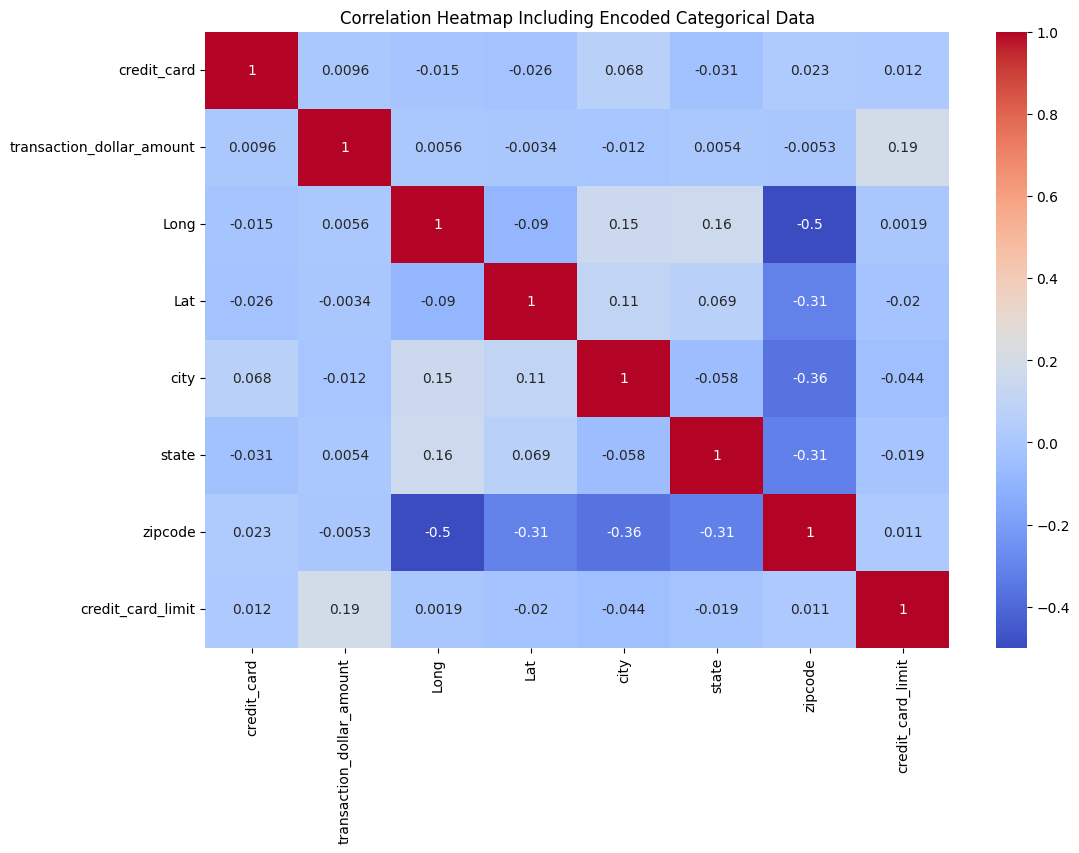

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the data to avoid changing the original DataFrame
data_encoded = data.copy()

# Identify categorical columns (columns with dtype 'object')
categorical_columns = data_encoded.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_encoded[column] = le.fit_transform(data_encoded[column].astype(str))  # Convert to string in case of mixed types
    label_encoders[column] = le

# Now data_encoded contains numeric representations of the original categorical data
# Select only numeric columns for correlation analysis
numeric_columns = data_encoded.select_dtypes(include=[np.number])

# Plot the correlation heatmap including encoded categorical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Including Encoded Categorical Data')
plt.show()


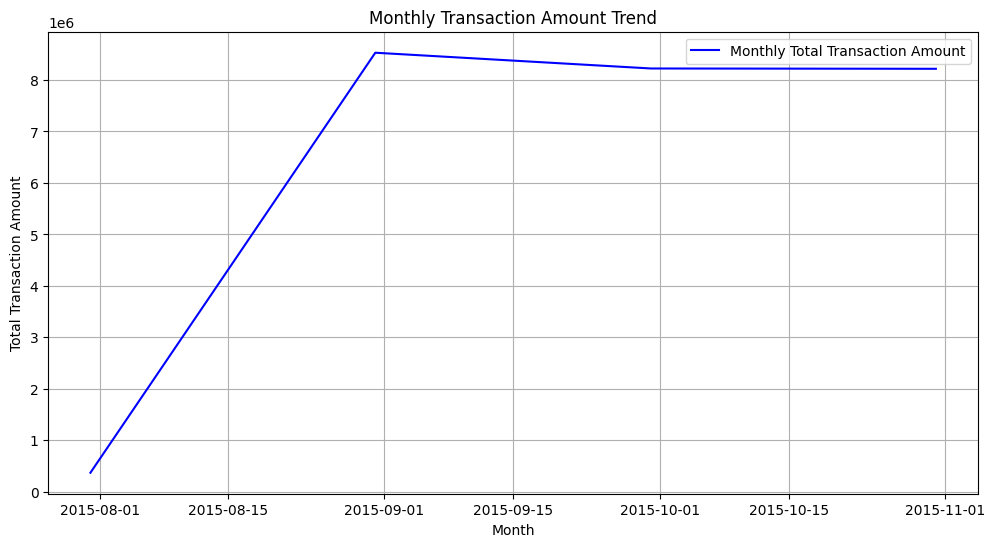

In [ ]:
import matplotlib.pyplot as plt

# Resample the data to monthly frequency and sum the transaction amounts
monthly_totals = data['transaction_dollar_amount'].resample('M').sum()

# Plot the monthly transaction amount trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals, label='Monthly Total Transaction Amount', color='blue')  # Add label for legend

# Add labels and title
plt.title('Monthly Transaction Amount Trend')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')

# Add legend to the plot
plt.legend(loc='best')

# Show the plot
plt.grid(True)  # Optional: Add grid for better readability
plt.show()


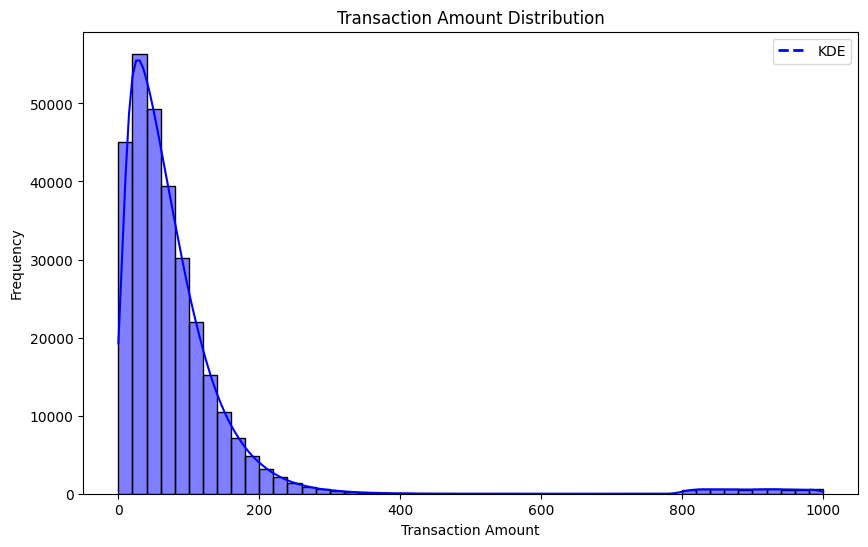

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of Transaction Amounts
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(data['transaction_dollar_amount'], bins=50, kde=True, color='blue')

# Add labels and title
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Manually add legend for the KDE line
# Since `histplot` does not return a line object for the KDE, we need to use a workaround
# We can use `plt.Line2D` to create a dummy line for the legend
from matplotlib.lines import Line2D

# Create a dummy line for the KDE
kde_line = Line2D([0], [0], color='blue', lw=2, linestyle='--')  # Match color and linestyle with KDE

# Add legend
plt.legend([kde_line], ['KDE'], loc='upper right')

# Show the plot
plt.show()


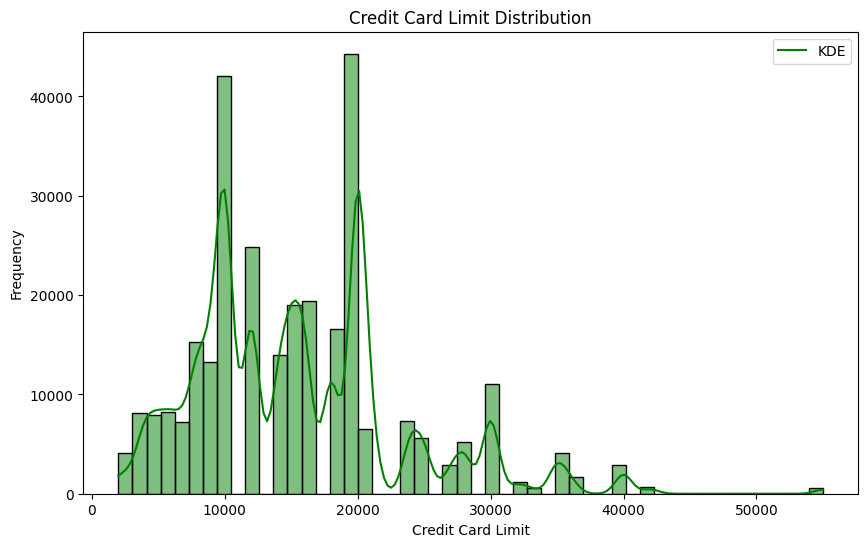

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of Credit Card Limits
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(data['credit_card_limit'], bins=50, kde=True, color='green')

# Add labels and title
plt.title('Credit Card Limit Distribution')
plt.xlabel('Credit Card Limit')
plt.ylabel('Frequency')

# Manually add legend for the KDE line
plt.legend(['KDE'], loc='upper right')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


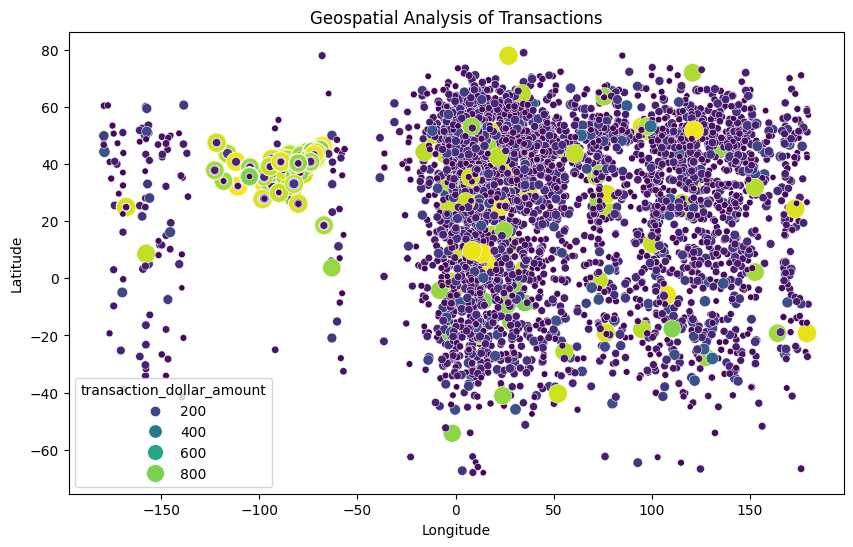

In [ ]:
# Geospatial Analysis: Transaction locations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Long'], y=data['Lat'], hue=data['transaction_dollar_amount'], palette='viridis', size=data['transaction_dollar_amount'], sizes=(20, 200))
plt.title('Geospatial Analysis of Transactions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
### Feature Engineering

# Creating additional time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [ ]:
# Ensure the index is sorted
data.sort_index(inplace=True)

# Calculate transaction velocity
data['transactions_per_hour'] = data.groupby('credit_card')['transaction_dollar_amount'].transform(lambda x: x.rolling('1H').count())

# Calculate rolling average of transaction amounts for the past week
data['rolling_amount_7d'] = data['transaction_dollar_amount'].rolling('7D').mean()

# Calculate ratio of transaction amount to credit limit
data['amount_per_limit'] = data['transaction_dollar_amount'] / data['credit_card_limit']


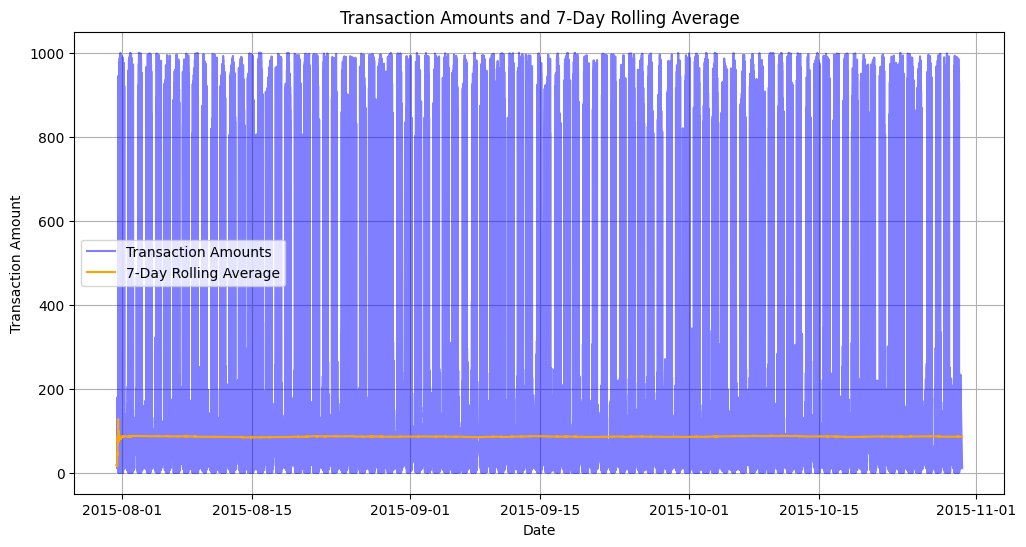

In [ ]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by datetime index
data.sort_index(inplace=True)

# Plot the rolling average of transaction amounts
plt.figure(figsize=(12, 6))

# Plot the raw transaction amounts
plt.plot(data.index, data['transaction_dollar_amount'], label='Transaction Amounts', alpha=0.5, color='blue')

# Plot the rolling average
plt.plot(data.index, data['rolling_amount_7d'], label='7-Day Rolling Average', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amounts and 7-Day Rolling Average')

# Add a legend to the plot
plt.legend(loc='best')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Aggregating data to create cardholder-level features
card_features = data.groupby('credit_card').agg(
    avg_transaction_amount=('transaction_dollar_amount', 'mean'),
    total_transaction_amount=('transaction_dollar_amount', 'sum'),
    transaction_count=('transaction_dollar_amount', 'count'),
    avg_amount_per_limit=('amount_per_limit', 'mean'),
    avg_transactions_per_hour=('transactions_per_hour', 'mean')
).reset_index()

# Merging cardholder-level features back to the original data
data = data.merge(card_features, on='credit_card', how='left')


In [ ]:
# Assuming 'transaction_dollar_amount' and 'credit_card' are columns in your DataFrame

# Average transaction amount per credit card
data['avg_transaction_amount'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('mean')

# Total transaction amount per credit card
data['total_transaction_amount'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('sum')

# Transaction count per credit card
data['transaction_count'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('count')


In [ ]:
### Scaling and Data Preparation

# Features for scaling
features = ['transaction_dollar_amount', 'credit_card_limit', 'avg_transaction_amount',
            'total_transaction_amount', 'transaction_count', 'amount_per_limit',
            'hour', 'day_of_week', 'is_weekend', 'transactions_per_hour', 'rolling_amount_7d']

X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
# X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)
# Splitting the dataset while keeping track of indices
X_train, X_test, train_idx, test_idx = train_test_split(X_scaled, data.index, test_size=0.3, random_state=42)

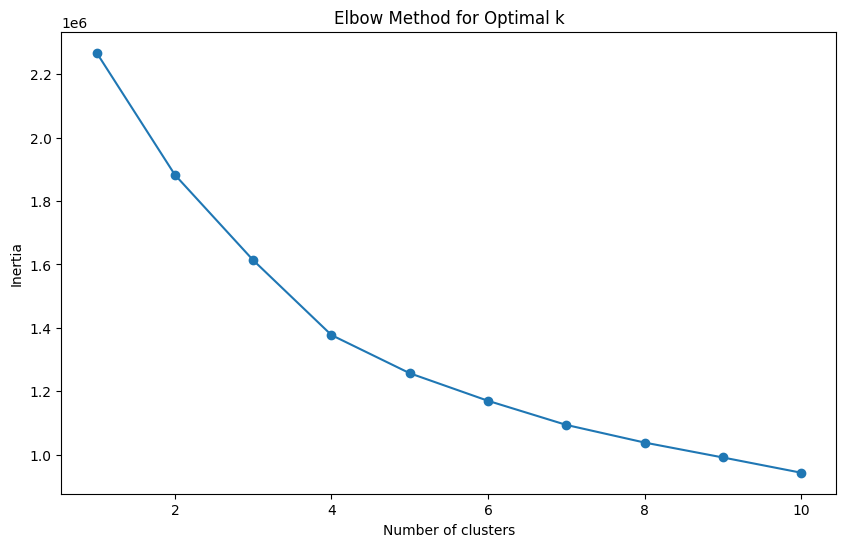

In [ ]:
### 1. Optimize K-Means Clustering

# Elbow Method to determine optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choosing optimal k (e.g., 4 or 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_train)

# Predict cluster labels and distances to cluster center
train_clusters = kmeans.predict(X_train)
test_clusters = kmeans.predict(X_test)

train_distances = np.linalg.norm(X_train - kmeans.cluster_centers_[train_clusters], axis=1)
test_distances = np.linalg.norm(X_test - kmeans.cluster_centers_[test_clusters], axis=1)

# Flag anomalies using the 95th percentile distance threshold
distance_threshold_train = np.percentile(train_distances, 95)
distance_threshold_test = np.percentile(test_distances, 95)

train_anomalies_kmeans = train_distances > distance_threshold_train
test_anomalies_kmeans = test_distances > distance_threshold_test

In [ ]:
print(np.isnan(X_train).sum())  # Check for NaN values in training data
print(np.isinf(X_train).sum())  # Check for infinite values in training data


0
0


In [ ]:
X_train = np.nan_to_num(X_train)  # Replace NaN values with 0 or other suitable value


In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Define parameter ranges
n_estimators_list = [100, 200]
max_samples_list = ['auto', 0.8, 0.9]
contamination_list = [0.01, 0.02, 0.05]

best_model = None
best_score = -np.inf

# Iterate over parameter combinations
for n_estimators in n_estimators_list:
    for max_samples in max_samples_list:
        for contamination in contamination_list:
            iso_forest = IsolationForest(n_estimators=n_estimators,
                                         max_samples=max_samples,
                                         contamination=contamination,
                                         random_state=42)
            iso_forest.fit(X_train)

            # Calculate anomaly scores
            train_anomaly_scores = iso_forest.decision_function(X_train)
            test_anomaly_scores = iso_forest.decision_function(X_test)

            # Evaluate the model (here we use a proxy metric)
            # Example metric: Mean of the train anomaly scores
            score = -np.mean(train_anomaly_scores)  # More negative scores indicate more anomalies

            if score > best_score:
                best_score = score
                best_model = iso_forest

# Output best model parameters
print(f"Best Isolation Forest parameters: n_estimators={best_model.n_estimators}, "
      f"max_samples={best_model.max_samples}, contamination={best_model.contamination}")

# # Fit and predict with the best model
# train_anomaly_scores = best_model.decision_function(X_train)
# test_anomaly_scores = best_model.decision_function(X_test)

# train_anomalies_iforest = best_model.predict(X_train) == -1
# test_anomalies_iforest = best_model.predict(X_test) == -1


Best Isolation Forest parameters: n_estimators=100, max_samples=0.9, contamination=0.05


In [ ]:
from sklearn.ensemble import IsolationForest

# Instantiate the Isolation Forest with the best parameters
best_iso_forest = IsolationForest(n_estimators=100,
                                   max_samples=0.9,
                                   contamination=0.05,
                                   random_state=42)

# Fit the model on the training data
best_iso_forest.fit(X_train)

# Predict anomalies on the training and test data
train_anomaly_scores = best_iso_forest.decision_function(X_train)
test_anomaly_scores = best_iso_forest.decision_function(X_test)

# Detect anomalies (anomalies are labeled as -1)
train_anomalies_iforest = best_iso_forest.predict(X_train) == -1
test_anomalies_iforest = best_iso_forest.predict(X_test) == -1

# Output the results
print(f"Number of anomalies in training data: {np.sum(train_anomalies_iforest)}")
print(f"Number of anomalies in test data: {np.sum(test_anomalies_iforest)}")


Number of anomalies in training data: 10311
Number of anomalies in test data: 4619


In [ ]:
### 3. Additional Anomaly Detection Methods (LOF and One-Class SVM)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
train_anomalies_lof = lof.fit_predict(X_train) == -1
test_anomalies_lof = lof.fit_predict(X_test) == -1

# One-Class SVM
ocsvm = OneClassSVM(gamma='auto', nu=0.01)
ocsvm.fit(X_train)
train_anomalies_ocsvm = ocsvm.predict(X_train) == -1
test_anomalies_ocsvm = ocsvm.predict(X_test) == -1


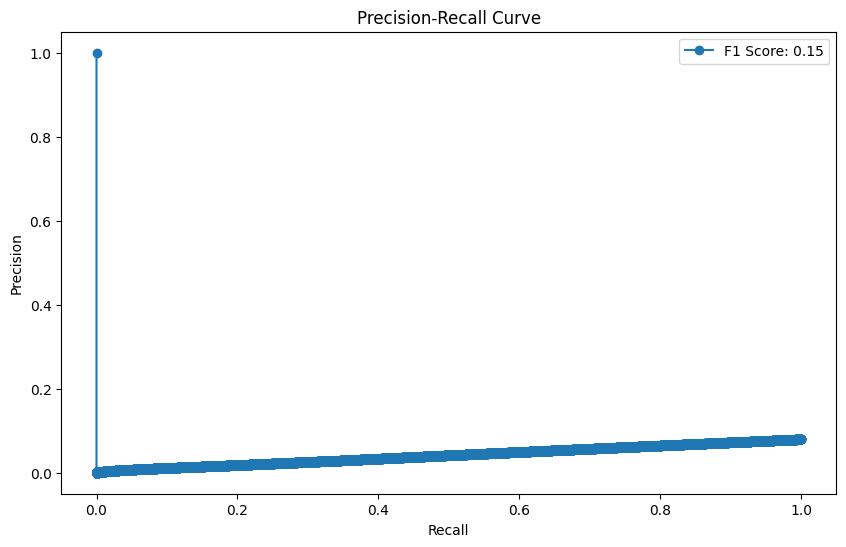

In [ ]:
### 4. Ensemble Approach for Anomaly Detection

# Combine multiple methods for final fraud flagging
final_train_anomalies = (train_anomalies_kmeans | train_anomalies_iforest | train_anomalies_lof | train_anomalies_ocsvm)
final_test_anomalies = (test_anomalies_kmeans | test_anomalies_iforest | test_anomalies_lof | test_anomalies_ocsvm)

# Evaluate model using precision-recall curve
precision, recall, thresholds = precision_recall_curve(final_test_anomalies, test_anomaly_scores)
epsilon = 1e-10  # small constant
f1 = 2 * (precision * recall) / (precision + recall + epsilon)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o', label=f'F1 Score: {np.max(f1):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# ROC-AUC Plot for each model

def plot_roc_auc(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

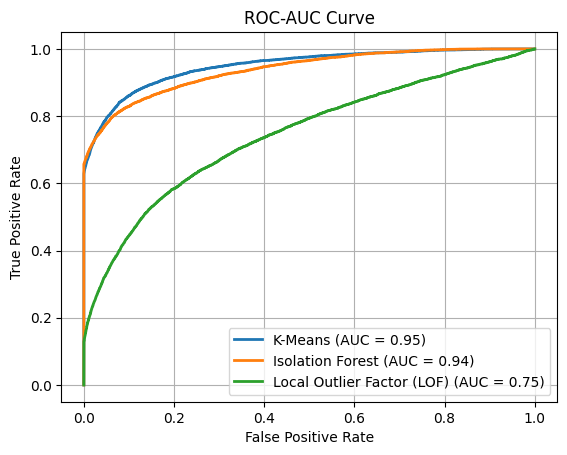

In [ ]:
# K-Means ROC-AUC
plot_roc_auc(final_test_anomalies, test_distances, 'K-Means')

# Isolation Forest ROC-AUC
plot_roc_auc(final_test_anomalies, -test_anomaly_scores, 'Isolation Forest')

# LOF ROC-AUC
plot_roc_auc(final_test_anomalies, -lof.negative_outlier_factor_, 'Local Outlier Factor (LOF)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Summary of Anomaly Detection Results
Total number of anomalies detected by K-Means:  4419
Total number of anomalies detected by Isolation Forest:  4619
Total number of anomalies detected by LOF:  884
Total number of anomalies detected by One-Class SVM:  898
Total number of anomalies detected by the Ensemble approach:  7039


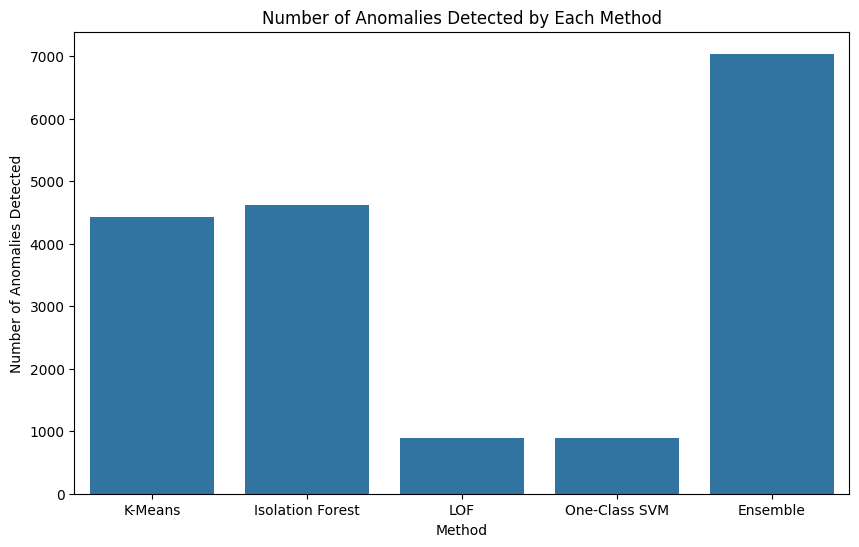

Displaying a few flagged transactions:
             credit_card  transaction_dollar_amount  is_fraud
191870  3951632727431524                     303.34      True
167891  9711468735134956                     216.73      True
231608  4318352196714983                      56.26      True
56460   9681744051023898                     195.47      True
146899  4832198644199161                     543.63      True
187499  2239759218122779                     143.75      True
31424   2505223645294729                      20.24      True
80937   6049616542527821                     911.67      True
235630  7794694461432561                      99.81      True
214056  5293204730208718                     220.97      True
Flagged transactions have been saved to 'flagged_fraud_transactions.csv'.


In [ ]:
# Print summary of the results
print("Summary of Anomaly Detection Results")

# Summary of flagged anomalies
print("Total number of anomalies detected by K-Means: ", np.sum(test_anomalies_kmeans))
print("Total number of anomalies detected by Isolation Forest: ", np.sum(test_anomalies_iforest))
print("Total number of anomalies detected by LOF: ", np.sum(test_anomalies_lof))
print("Total number of anomalies detected by One-Class SVM: ", np.sum(test_anomalies_ocsvm))
print("Total number of anomalies detected by the Ensemble approach: ", np.sum(final_test_anomalies))

# Plot summary of the anomalies detected by each method
methods = ['K-Means', 'Isolation Forest', 'LOF', 'One-Class SVM', 'Ensemble']
anomalies_count = [
    np.sum(test_anomalies_kmeans),
    np.sum(test_anomalies_iforest),
    np.sum(test_anomalies_lof),
    np.sum(test_anomalies_ocsvm),
    np.sum(final_test_anomalies)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=anomalies_count)
plt.title('Number of Anomalies Detected by Each Method')
plt.xlabel('Method')
plt.ylabel('Number of Anomalies Detected')
plt.show()
# Create an empty column for 'is_fraud' in the full data set
data['is_fraud'] = False  # Initialize all to False

# Assign the anomaly results back to the corresponding rows in the original dataset
data.loc[test_idx, 'is_fraud'] = final_test_anomalies  # Assign anomalies to test set indices

### 3. Display flagged transactions
# Filter the flagged transactions (anomalies) from the original dataset
fraud_transactions = data.loc[test_idx][final_test_anomalies]  # Filter the rows flagged as anomalies

# Display a few flagged transactions
print("Displaying a few flagged transactions:")
print(fraud_transactions[['credit_card', 'transaction_dollar_amount', 'is_fraud']].head(10))
# Save flagged transactions to a CSV file for further review
fraud_transactions.to_csv('flagged_fraud_transactions.csv', index=False)
print("Flagged transactions have been saved to 'flagged_fraud_transactions.csv'.")
